# Projeto B - Previsão de Faturamento

<sub>Projeto para a disciplina de **Estatística** (Módulo 4) do Data Science Degree (turma de julho de 2020)</sub>

## Equipe

* Felipe Lima de Oliveira
* Mário Henrique Romagna Cesa
* Tsuyioshi Valentim Fukuda
* Fernando Raineri Monari

Link para [projeto no Github](https://github.com/flimao/case-previsao-faturamento)

## Introdução

blah blah blah inicial

In [1]:
# importação de bibliotecas

import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# importação de bibliotecas de análise
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from pmdarima.arima import auto_arima

# teste para verificar estacionariedade (Dickey-Fuller: https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)
from statsmodels.tsa.stattools import adfuller

# metricas 
from sklearn.metrics import mean_absolute_percentage_error as smape, mean_squared_error as smse, mean_absolute_error as smae 

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (10, 4)

## Importação dos dados e análise inicial

Inicialmente, vamos importar e ver a aparência geral dos dados:

* número e nome de colunas
* qual o tipo de dados de cada coluna
* Algumas linhas do dataset

In [2]:
# importar base e iniciar a análise inicial
ts_raw = pd.read_csv(r'sim_ts.txt', sep = '\t')
ts_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   vlr      511 non-null    float64
 1   date     511 non-null    object 
 2   produto  511 non-null    object 
dtypes: float64(1), object(2)
memory usage: 12.1+ KB


In [3]:
ts_raw.describe()

,vlr
count,5.110000e+02
mean,4.187929e+08
std,6.272376e+08
min,0.000000e+00
25%,6.472878e+05
50%,2.261791e+07
75%,1.028848e+09
max,1.990000e+09


In [4]:
ts_raw.sample(5).sort_index()

,vlr,date,produto
106,1.643129e+09,2018-10-01,alimenticio
254,5.192960e+05,2012-05-01,auxilio_final_de_ano
414,1.686625e+05,2017-10-01,bonificacao
461,1.408867e+07,2017-09-01,saude
471,2.006257e+07,2018-07-01,saude


### Limpeza dos dados

Vamos definir algumas funções de limpeza dos dados.

Ao final desse processo, teremos três estruturas de dados:

- um *dataframe* `ts` associando os meses aos faturamentos e aos produtos;
- um dicionário `tsd` cujas chaves serão os produtos e os valores serão *Series* associando meses e faturamentos (contanto desde o lançamento do produto); e
- um *dataframe* `tswide` onde cada coluna corresponde à série histórica de um produto.

Ao dicionário `tsd` será adicionada uma chave, `total`, contendo a soma dos faturamentos de todos os produtos mês a mês.

In [5]:
# limpeza 1: conversão de tipos

def conversao_tipos(df):
    df = df.copy()

    df['date'] = df['date'].astype('datetime64[ns]')
    df['produto'] = df['produto'].astype('category')
    return df

# limpeza 2: setar a coluna de data como indice
def setar_indice_data(df):
    df = df.copy()

    s = df.set_index('date')['vlr']

    return s

# limpeza 3: gerar dados de meses faltantes

def gerar_dados_faltantes(s):
    s = s.copy()

    s = s.asfreq('MS')

    return s

# limpeza 4: preencher missings
def preencher_missings(s):
    s = s.copy()

    # s = s.interpolate()

    return s

# executar limpeza para o DF ts
# não é possível setar a data como índice porque há multiplas entradas com mesmo mês.
# isso geraria problemas para funções de agregação (groupby's etc) e JOIN's.
# logo, para o 
ts = (ts_raw
    .pipe(conversao_tipos)
)


In [6]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   vlr      511 non-null    float64       
 1   date     511 non-null    datetime64[ns]
 2   produto  511 non-null    category      
dtypes: category(1), datetime64[ns](1), float64(1)
memory usage: 8.8 KB


In [7]:
ts.sample(10).sort_index()

,vlr,date,produto
51,1.195214e+09,2014-03-01,alimenticio
129,1.848746e+09,2020-09-01,alimenticio
234,6.758371e+05,2010-09-01,auxilio_final_de_ano
279,5.120191e+05,2014-06-01,auxilio_final_de_ano
286,1.359434e+06,2015-01-01,auxilio_final_de_ano
336,9.872129e+05,2019-03-01,auxilio_final_de_ano
366,1.080984e+05,2012-05-01,bonificacao
389,1.450919e+05,2015-02-01,bonificacao
422,1.495167e+05,2018-06-01,bonificacao
506,2.530390e+07,2021-06-01,saude


Vamos agora construir o dicionário `tsd` e o dataframe `tswide`:

In [8]:
produtos = ts['produto'].cat.categories

tsd = {}
for produto in produtos:
    ts_produto = ts[ts['produto'] == produto]

    # finalizar limpeza para Series dentro do dicionário
    s_prod = (ts_produto
        .pipe(setar_indice_data)
        .pipe(gerar_dados_faltantes)
        .pipe(preencher_missings)
    )
    s_prod.name = f'faturamento_{produto}'
    tsd[produto] = s_prod

tswide = pd.DataFrame(tsd)

sprodtotal = tswide.sum(axis = 1)
sprodtotal.name = 'faturamento_total'
tsd['total'] = sprodtotal

for produto, s in tsd.items():
    print(f"Quantidade de dados faltantes para o produto '{produto}': {s.isna().sum()}")
    print(f"Lançamento do produto '{produto}': {s.index[0].strftime('%Y-%m-%d')}")
    print('')

# confirmação do dataframe limpo
# ts.info()

Quantidade de dados faltantes para o produto 'alimenticio': 0
Lançamento do produto 'alimenticio': 2009-12-01

Quantidade de dados faltantes para o produto 'auxilio_final_de_ano': 0
Lançamento do produto 'auxilio_final_de_ano': 2009-12-01

Quantidade de dados faltantes para o produto 'bonificacao': 30
Lançamento do produto 'bonificacao': 2012-01-01

Quantidade de dados faltantes para o produto 'saude': 0
Lançamento do produto 'saude': 2016-11-01

Quantidade de dados faltantes para o produto 'transporte': 0
Lançamento do produto 'transporte': 2015-01-01

Quantidade de dados faltantes para o produto 'total': 0
Lançamento do produto 'total': 2009-12-01



#### Tratamento de valores faltantes

Há alguns padrões interessantes de valores faltantes para alguns produtos:

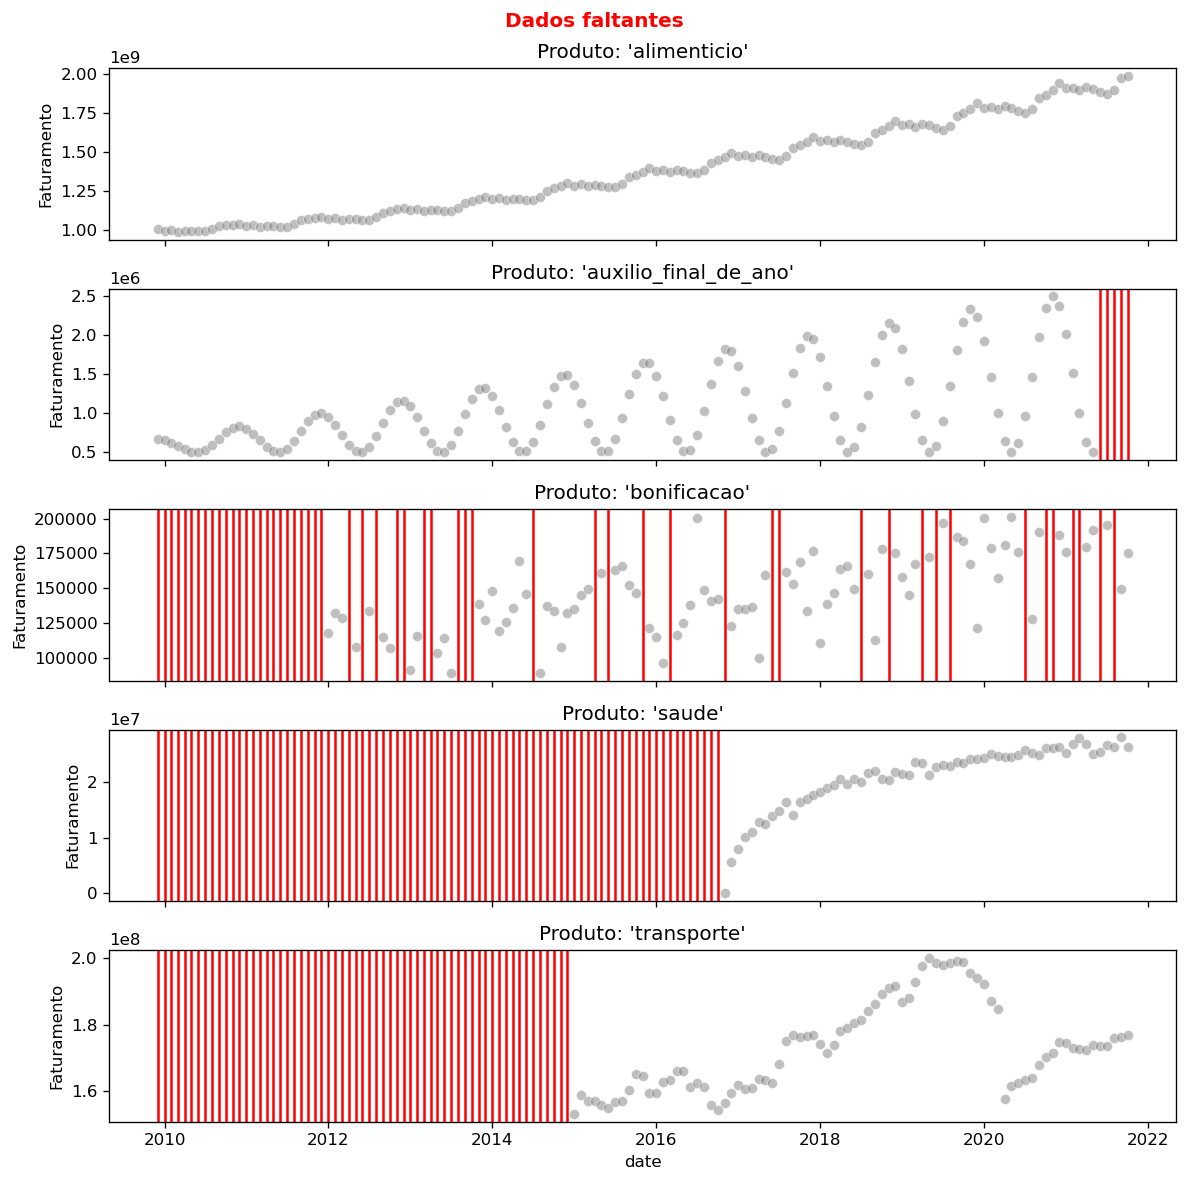

In [9]:
n_produtos = len(produtos)

fig, axs = plt.subplots(nrows = n_produtos, ncols = 1, sharex = True, figsize = (10, 10))

for i, produto in enumerate(produtos):
    data_full = tswide[produto]
    data_missings = data_full[data_full.isna()]
    
    ax = axs[i]
    sns.scatterplot(data = data_full, ax = ax, color = 'gray', alpha = 0.5)
    if data_missings.shape[0] > 0:
        for x in data_missings.index:
            ax.axvline(x = x, color = 'red')

    ax.set_title(f"Produto: '{produto}'")
    ax.set_ylabel('Faturamento')

fig.suptitle('Dados faltantes', color = 'red', fontweight = 1000)
plt.tight_layout()
plt.show()

Claramente, vê-se que:

- **Não há nenhum dado faltante para o produto `alimenticio`**;
- Os produtos `saude` e `transporte` foram introduzidos após o início da série histórica. **Não há nenhum dado faltante após o lançamento desses produtos**.
- O produto `auxilio_final_de_ano` tem dados faltantes seguidos após maio de 2021. Dado que este produto corresponde ao segundo menor faturamento entre todos os produtos, e que oscila cada vez mais em torno de uma média que aparentemente cresce pouco, **é razoável assumir que foi descontinuado em meados de 2021**.
- O produto `bonificacao` também foi introduzido após o início da série histórica; no entanto, contém dados faltantes aparentemente de forma aleatória.

Logo, devemos avaliar o que faremos a respeito dos dados faltantes do produto `bonificacao`.

Nota-se no gráfico acima que o produto `bonificacao` responde por um faturamento 4 ordens de magnitude menor que o produto `alimenticio`. Independente do tratamento a ser dado, o efeito sobre o faturamento total será mínimo.

Por conta disso, vamos assumir que os dados faltantes na série `bonificacao` são 0.

In [10]:
# OBS: antes do lançamento, o faturamento deve ser nan. 
# Isso auxiliará na dropagem de valores antes do lançamento depois
# Caso queiramos a série completa (incluindo os nan), basta acessarmos
# o DF `tswide`

# construindo um dicionario com a data de lancamento de cada produto
# primeira data com dados não nulos
lancamentos = { }

for produto in produtos:
    s = tsd[produto]
    lancamento = s.index[0]
    lancamentos[produto] = lancamento

# bonificacao: valores faltantes após lançamento do produto são 0
tswide['bonificacao'] = tswide['bonificacao'].fillna(0)
tswide.loc[:lancamentos['bonificacao'], 'bonificacao'] = np.nan

# auxilio_fim_de_ano: valores faltantes em 2021 são 0 (produto descontinuado)
tswide['auxilio_final_de_ano'] = tswide['auxilio_final_de_ano'].fillna(0)
tswide.loc[:lancamentos['auxilio_final_de_ano'], 'auxilio_final_de_ano'] = np.nan

Vamos agora reconstruir o dicionário `tsd` após completar os valores faltantes.

In [11]:
tsd = {}
for produto in produtos:
    sprod = tswide[produto].dropna()
    sprod.name = f'faturamento_{produto}'
    tsd[produto] = sprod

sprodtotal = tswide.sum(axis = 'columns')
tsd['total'] = sprodtotal

### Análise Exploratória - Faturamento total

Vamos primeiramente analisar o faturamento total contido na série histórica:

In [12]:
fat_total = tsd['total']
fat_total.describe()

count    1.430000e+02
mean     1.496520e+09
std      3.836341e+08
min      9.905806e+08
25%      1.122928e+09
50%      1.527953e+09
75%      1.861295e+09
max      2.193340e+09
dtype: float64

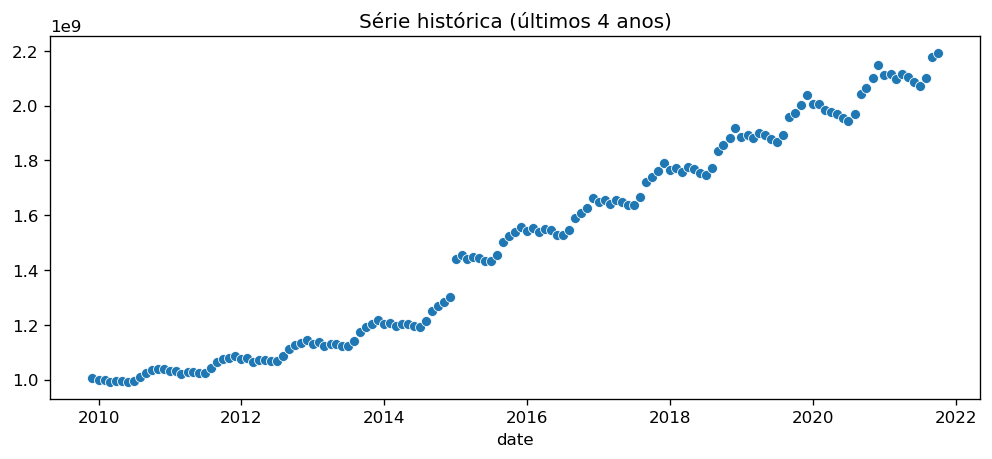

In [13]:
sns.scatterplot(data = fat_total)
plt.title('Série histórica (últimos 4 anos)')
plt.show()

Parece haver um salto entre 2014 e 2015 no faturamento total. 

Esse salto é devido ao lançamento de um outro produto, `transporte`. O faturamento deste novo produto é uma ordem de magnitude menor que o faturamento do produto `alimenticio` (como vimos brevemente no gráfico de dados faltantes e veremos com detalhes mais a frente), mas é o suficiente para que seja notado no faturamento total.

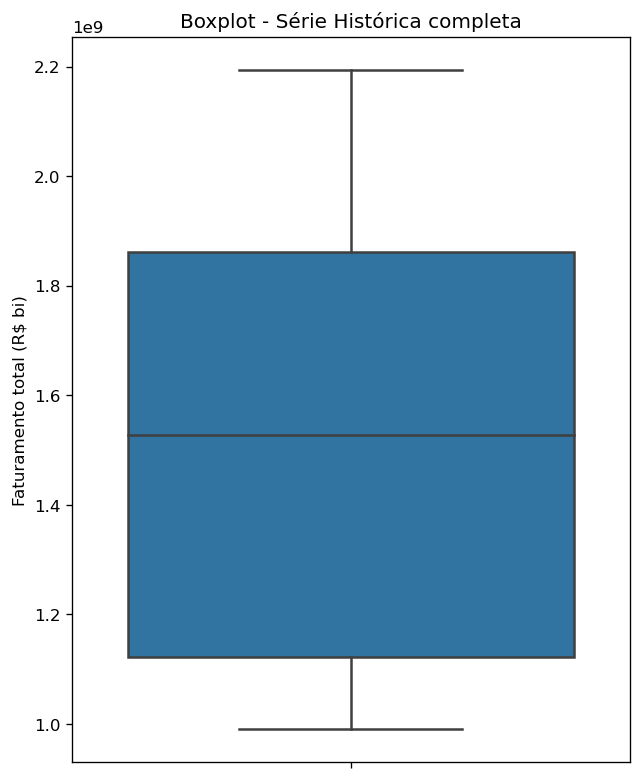

In [14]:
fig = plt.figure(figsize = (6, 8))
sns.boxplot(y = fat_total)
plt.ylabel('Faturamento total (R$ bi)')
plt.title('Boxplot - Série Histórica completa')
plt.show()

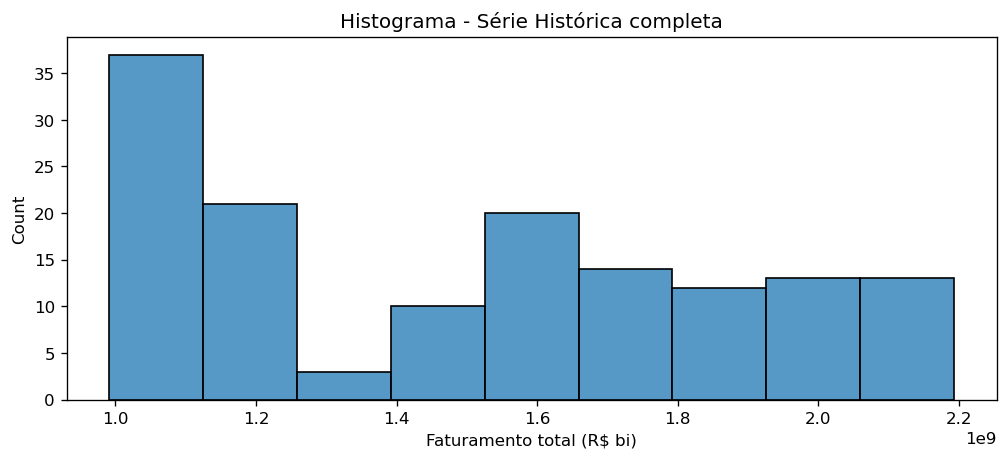

In [15]:
sns.histplot(fat_total)
plt.xlabel('Faturamento total (R$ bi)')
plt.title('Histograma - Série Histórica completa')
plt.show()

No entanto, medidas descritivas de séries temporais devem ser tomadas em relação ao tempo. Vamos separar essas medidas ano a ano:

In [16]:
n_anos = 4
anos_recentes = fat_total[fat_total.index >= dt.datetime.now() - dt.timedelta(days = n_anos * 365) + pd.tseries.offsets.YearBegin()]
anos_recentes.describe()

count    4.500000e+01
mean     1.961071e+09
std      1.257704e+08
min      1.748082e+09
25%      1.881462e+09
50%      1.969575e+09
75%      2.073233e+09
max      2.193340e+09
dtype: float64

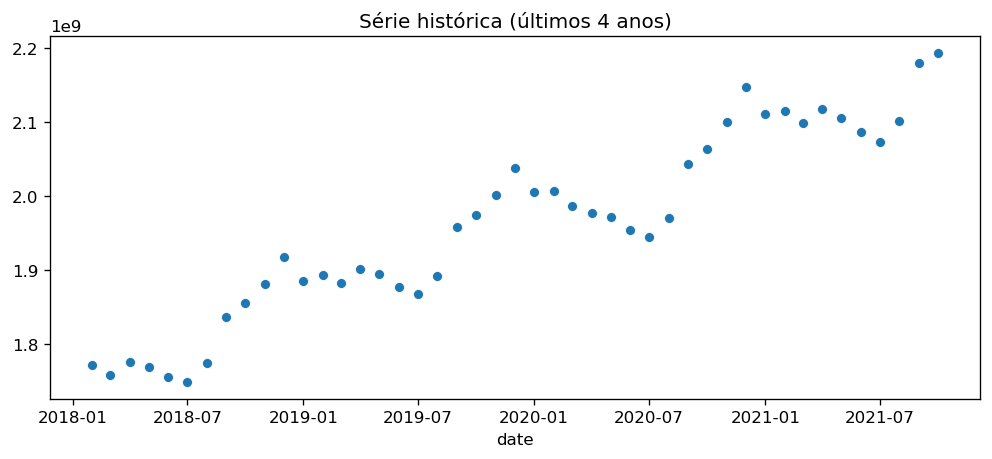

In [17]:
sns.scatterplot(data = anos_recentes)
plt.title(f'Série histórica (últimos {n_anos} anos)')
plt.show()

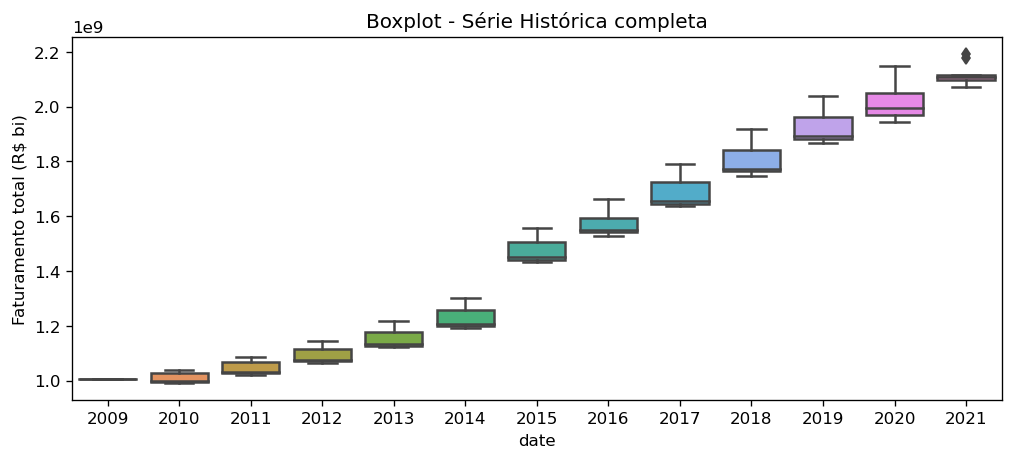

In [18]:
sns.boxplot(y = fat_total, x = fat_total.index.year)
plt.ylabel('Faturamento total (R$ bi)')
plt.title('Boxplot - Série Histórica completa')
plt.show()

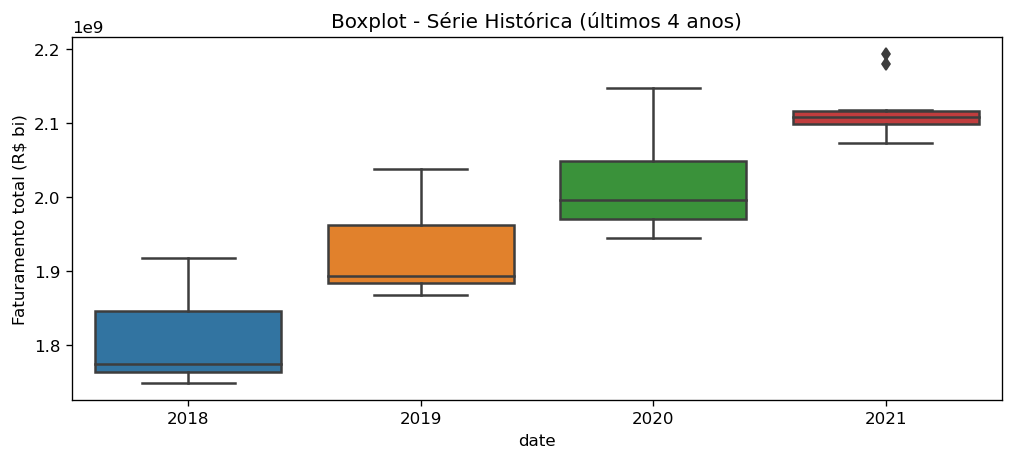

In [19]:

sns.boxplot(y = anos_recentes, x = anos_recentes.index.year)
plt.ylabel('Faturamento total (R$ bi)')
plt.title(f'Boxplot - Série Histórica (últimos {n_anos} anos)')
plt.show()

Parece haver alguns *outliers* em 2021.

No entanto, a série de 2021 está incompleta (vai somente até outubro). Historicamente, há um salto no faturamento em agosto, o que pode estar causando essa deturpação das medidas descritivas.

Excluindo o ano de 2021...

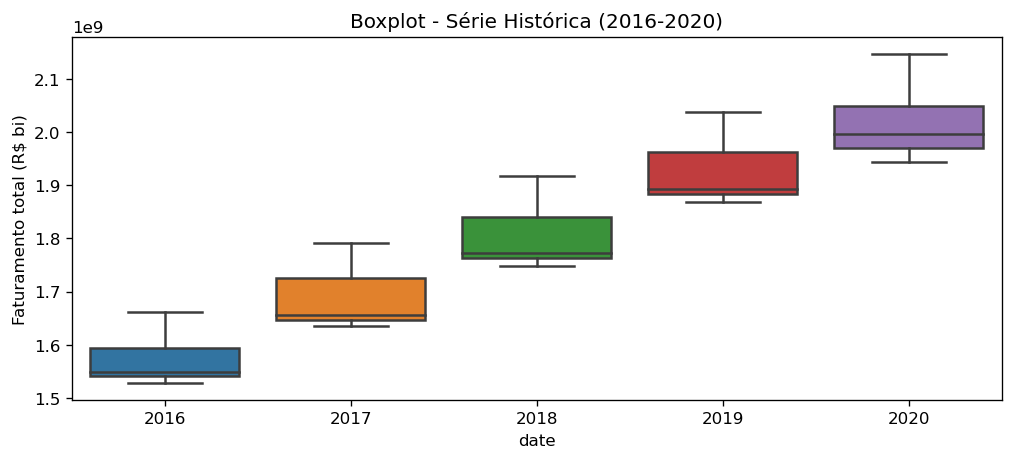

In [20]:
anos_recentes_exc2021 = fat_total[(fat_total.index >= '2016') & (fat_total.index < '2021')]
sns.boxplot(y = anos_recentes_exc2021, x = anos_recentes_exc2021.index.year)
plt.ylabel('Faturamento total (R$ bi)')
plt.title(f'Boxplot - Série Histórica (2016-2020)')
plt.show()

A pandemia se faz notar nos dados apenas com o aumento ligeiro da mediana em relação à distância entre o Q1 e o Q3.

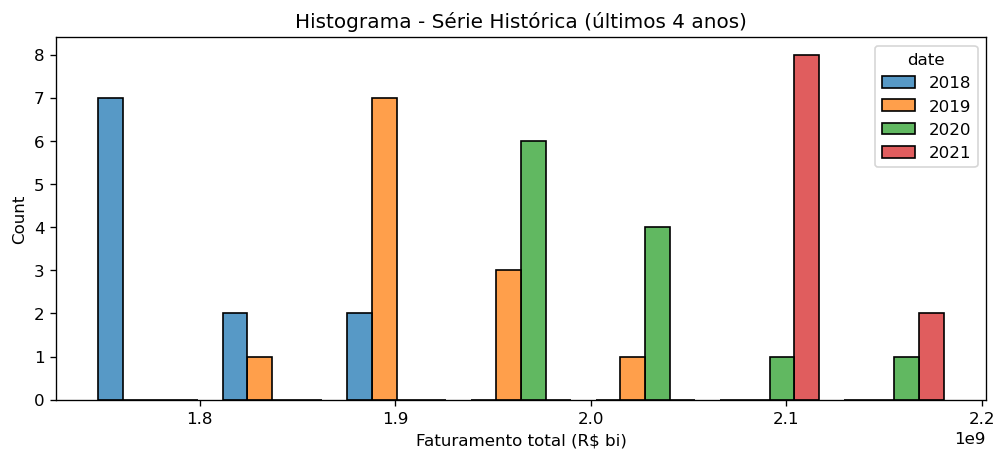

In [45]:
sns.histplot(x = anos_recentes, hue = anos_recentes.index.year, multiple = 'dodge', shrink = .8, common_norm = False, palette = sns.color_palette()[:4])
plt.xlabel('Faturamento total (R$ bi)')
plt.title(f'Histograma - Série Histórica (últimos {n_anos} anos)')
plt.show()

Os histogramas ano a ano estão melhor comportados que o histograma da série histórica completa.

Fazendo uma análise mês a mês para cada ano...

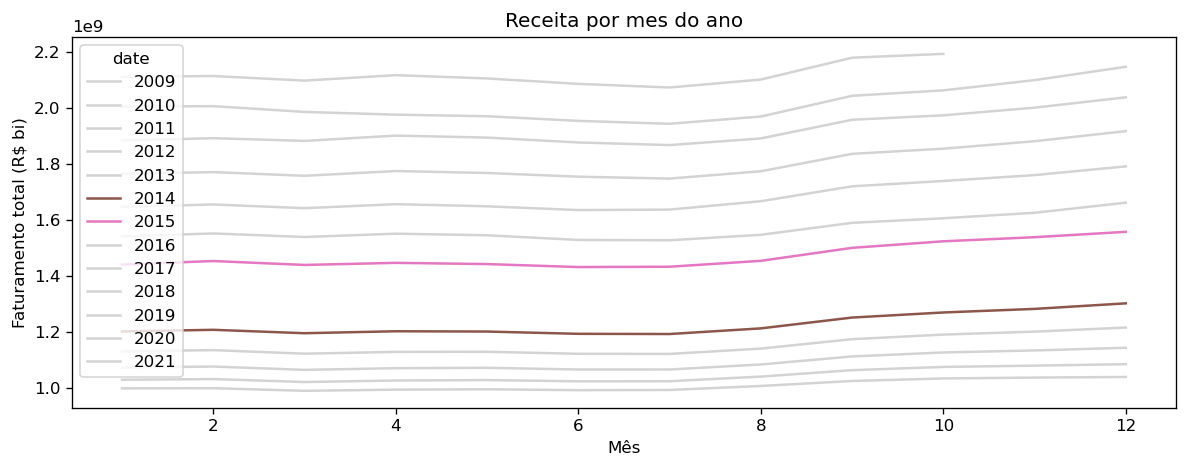

In [22]:
hue = fat_total.index.year

palette = []
for i, year in enumerate(hue.unique()):
    if year not in [2014, 2015]:
        palette += ['lightgray']
    else:
        palette += [sns.color_palette()[i]]

ax = sns.lineplot(
    y = fat_total, x = fat_total.index.month, 
    hue = fat_total.index.year,
    palette = palette
)
ax.set_xlabel('Mês')
ax.set_ylabel('Faturamento total (R$ bi)')
ax.set_title(f"Receita por mes do ano")
plt.tight_layout()
plt.show()

... nota-se claramente o salto dado de 2014 para 2015 com a entrada do novo produto.

### Análise de Série Temporal - Faturamento total

Para que a série de faturamentos mensais totais possa ser decomposta, é necessário que ela seja estacionária. 

Não parece ser, mas vamos testar através do teste estatístico de Dickey-Fuller.

A hipótese nula do teste de Dickey-Fuller é que a série é um passeio aleatório (random walk):

In [23]:
testedf = adfuller(fat_total)
pvalor = testedf[1]
alpha = 0.05

print(f'Valor-p: {pvalor:.3%}', end = '')

if pvalor < alpha:
    print(f' < {alpha:.0%}')
    print('    Série de faturamentos mensais é estacionária. Rejeita-se a hipótese de a série ser um passeio aleatório.')
else:
    print(f' > {alpha:.0%}')
    print('    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula.')

Valor-p: 98.342% > 5%
    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula.


Isso é evidenciado pela decomposição da série temporal:

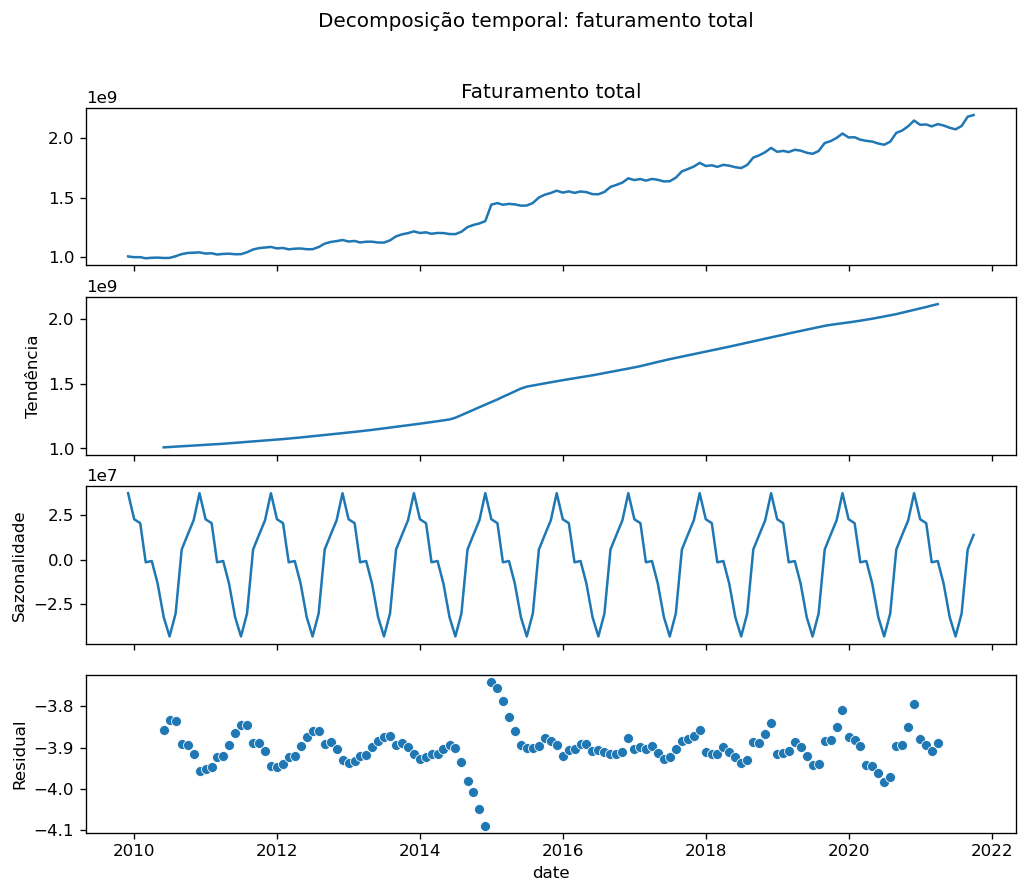

In [24]:
decomp_total = seasonal_decompose(fat_total)

# plot      
fig, axs = plt.subplots(nrows = 4, figsize = (10, 8), sharex = True)

sns.lineplot(data = fat_total, ax = axs[0])
axs[0].set_title('Faturamento total')

sns.lineplot(data = decomp_total.trend, ax = axs[1])
axs[1].set_ylabel('Tendência')

sns.lineplot(data = decomp_total.seasonal, ax = axs[2])
axs[2].set_ylabel('Sazonalidade')

resid = (decomp_total.resid - fat_total.mean())/fat_total.std()
sns.scatterplot(data = resid, ax = axs[3])
axs[3].set_ylabel('Residual')

fig.suptitle(f"Decomposição temporal: faturamento total")
plt.show()

Como mostrado anteriormente, esta série temporal não é estacionária, o que podemos ver através dos resíduos padronizados do último quadro.

Para analisar e prever essa série temporal, é necessário um modelo mais completo, o ARIMA.

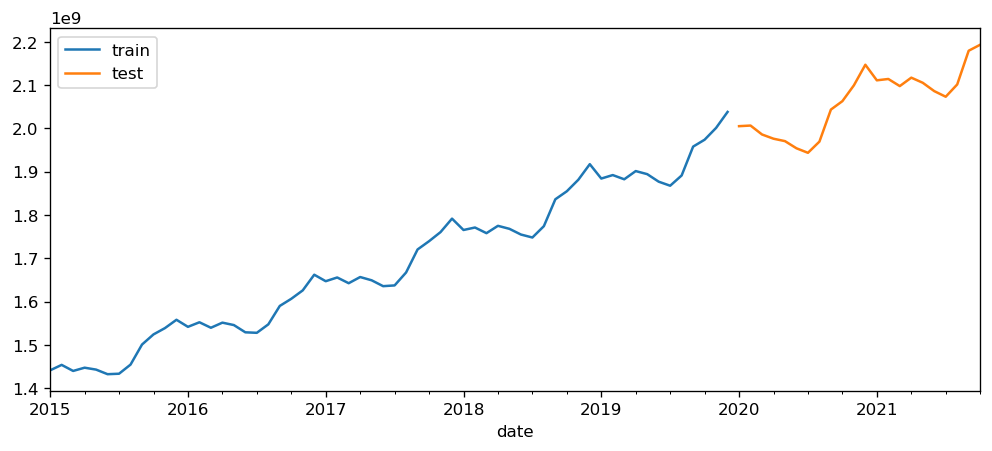

In [110]:
# excluindo o período pré-2015

test_begin = '2020-01-01'
total_train = fat_total['2015-01-01':test_begin].iloc[:-1]
total_test = fat_total[test_begin:]

total_train.plot(label = 'train')
total_test.plot(label = 'test')
plt.legend()
plt.show()

In [111]:
arimas = {}
arimas['total'] = auto_arima(
    y = total_train,
    start_p = 1, max_p = 3,
    d = None, #max_d = 4,
    start_q = 1, max_q = 3,
    start_P = 1, max_P = 3,
    D = None, #max_D = 4,
    start_Q = 1, max_Q = 3,
    #max_order = 6,
    m = 12,
    #alpha = 0.05
)


In [112]:
arimas['total'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   60
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -793.399
Date:                            Mon, 15 Nov 2021   AIC                           1588.799
Time:                                    23:21:08   BIC                           1590.649
Sample:                                         0   HQIC                          1589.495
                                             - 60                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.041e+13   2.46e+12      8.313      0.000    1.56e+13    2.52e+13
===================================================================================
Ljung-Box (L1) (Q):                   3.83   Jarque-Bera (JB):                 6.52
Prob(Q):                              0.05   Prob(JB):                         0.04
Heteroskedasticity (H):               0.57   Skew:                             0.59
Prob(H) (two-sided):                  0.27   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

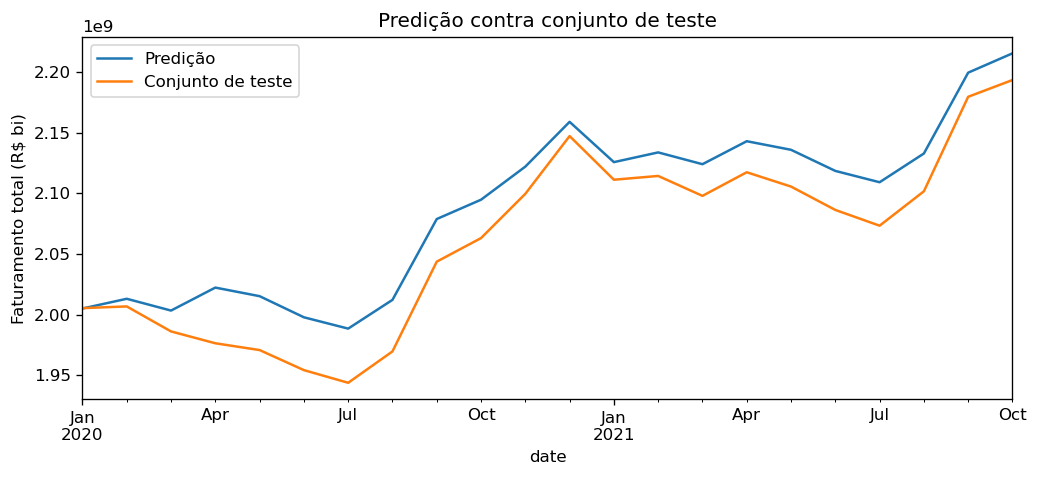

In [113]:
n_test_periods = total_test.shape[0]
arr_preds = arimas['total'].predict(n_test_periods)

idx = pd.date_range(freq = 'MS', start = test_begin, periods = n_test_periods)
preds = pd.Series(arr_preds, index = idx)
preds.name = 'yearly_preds'

preds.plot(label = 'Predição')
total_test.plot(label = 'Conjunto de teste')

plt.legend()
plt.ylabel('Faturamento total (R$ bi)')
plt.title('Predição contra conjunto de teste')
plt.show()

Vamos aplicar algumas métricas ao modelo:

In [114]:
kwargs_total = dict(
    y_true = total_test,
    y_pred = preds
)

metricas = dict(
    total = dict(
        mape = smape(**kwargs_total),
        rmse = np.sqrt(smse(**kwargs_total)),
        mae = smae(**kwargs_total)
    )
)

mape = metricas['total']['mape']
rmse = metricas['total']['rmse']
mae = metricas['total']['mae']

print(f'MAPE: {mape:.3%}')
print(f'RMSE: {rmse:.3e}')
print(f' MAE: {mae:.3e}')

MAPE: 1.341%
RMSE: 3.015e+07
 MAE: 2.740e+07


### Análise exploratória dos dados - Segregado por produto

Primeiramente vamos fazer uma análise das medidas descritivas dos dados completos.

In [39]:
tswide.describe()

,alimenticio,auxilio_final_de_ano,bonificacao,saude,transporte
count,1.430000e+02,1.420000e+02,117.000000,6.000000e+01,8.200000e+01
mean,1.387476e+09,1.023809e+06,109090.976536,2.089162e+07,1.729469e+08
std,2.965446e+08,5.517009e+05,68895.397270,5.826385e+06,1.340913e+07
min,9.900000e+08,0.000000e+00,0.000000,0.000000e+00,1.532707e+08
25%,1.122228e+09,6.029612e+05,0.000000,1.868296e+07,1.616310e+08
50%,1.364441e+09,8.884030e+05,133658.856529,2.275080e+07,1.726690e+08
75%,1.644394e+09,1.358786e+06,160731.244724,2.502346e+07,1.812734e+08
max,1.990000e+09,2.500000e+06,201331.273286,2.800000e+07,2.000000e+08


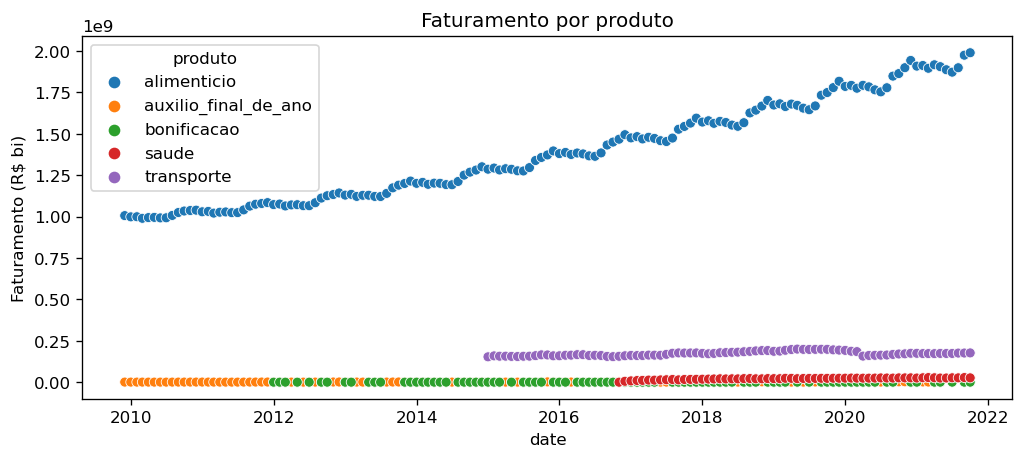

In [53]:
fig = plt.figure()
sns.scatterplot(data = ts, x = 'date', y = 'vlr', hue = 'produto') 
plt.ylabel('Faturamento (R$ bi)')
plt.title('Faturamento por produto')
plt.show()

Claramente os valores auferidos em cada produto tem ordens de grandeza totalmente diferentes. Por conta disso, não conseguimos enxergar as tendências dos produtos com valores que tem ordens de grandeza menores.

Melhor fazer um gráfico para cada produto, com escalas diferentes para os valores.

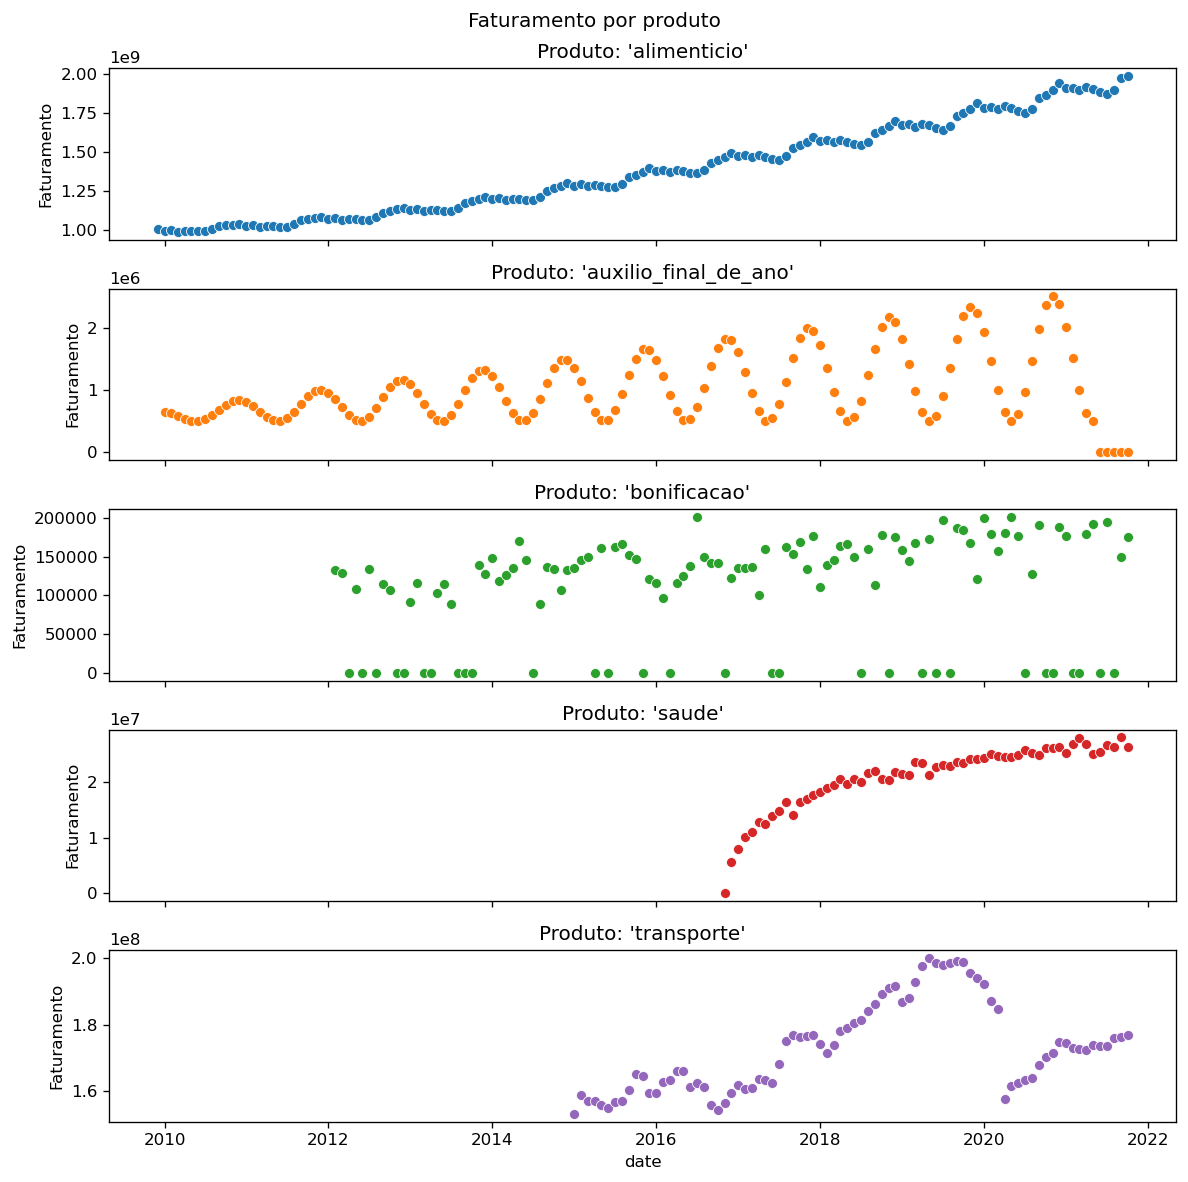

In [44]:
n_produtos = len(produtos)

palette = sns.color_palette(None, n_produtos)

fig, axs = plt.subplots(nrows = n_produtos, ncols = 1, sharex = True, figsize = (10, 10))

for i, produto in enumerate(produtos):
    ax = axs[i]
    sns.scatterplot(data = tsd[produto], ax = ax, color = palette[i])
    ax.set_title(f"Produto: '{produto}'")
    ax.set_ylabel('Faturamento')

fig.suptitle('Faturamento por produto')
plt.tight_layout()
plt.show()


Vamos seguir produto a produto.

### Análise Exploratória - produto `alimenticio`

Vamos seguir o mesmo roteiro seguido para analisar os faturamentos totalizados.

In [57]:
analise_produto = 'alimenticio'
fat = tsd[analise_produto]
fat.describe()

count    1.430000e+02
mean     1.387476e+09
std      2.965446e+08
min      9.900000e+08
25%      1.122228e+09
50%      1.364441e+09
75%      1.644394e+09
max      1.990000e+09
Name: faturamento_alimenticio, dtype: float64

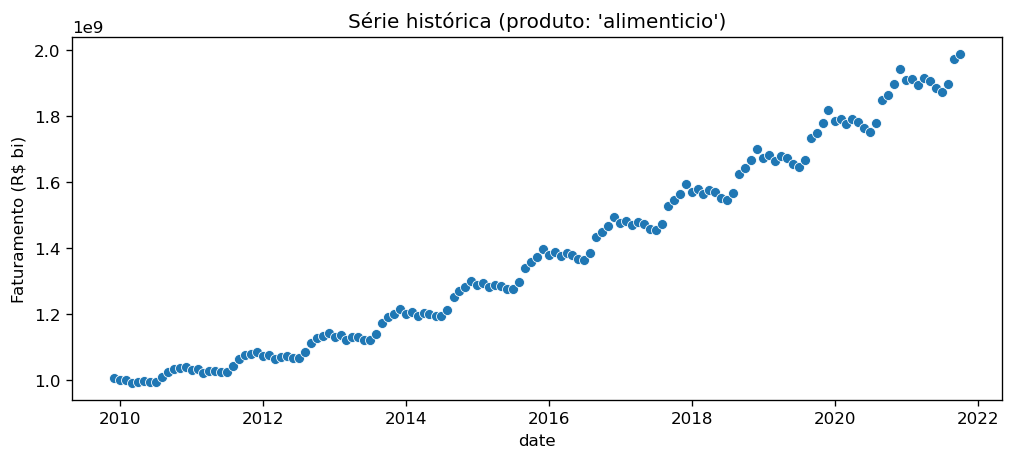

In [60]:
sns.scatterplot(data = fat)
plt.title(f"Série histórica (produto: '{analise_produto}')")
plt.ylabel("Faturamento (R$ bi)")
plt.show()

Inicialmente a série temporal parece regular, embora claramente não estacionária, tanto na média (série crescente) quanto no desvio padrão (oscilações crescentes).

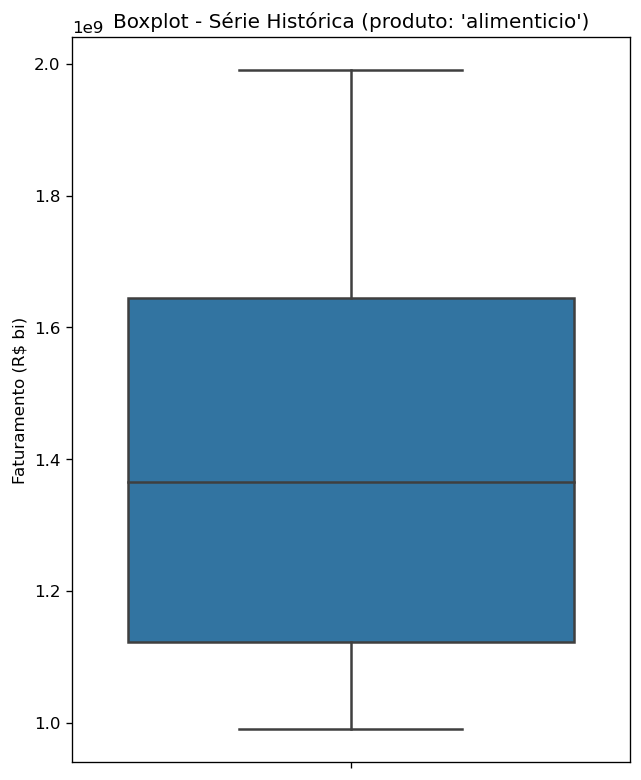

In [72]:
fig = plt.figure(figsize = (6, 8))
sns.boxplot(y = fat)
plt.ylabel('Faturamento (R$ bi)')
plt.title(f"Boxplot - Série Histórica (produto: '{analise_produto}')")
plt.show()

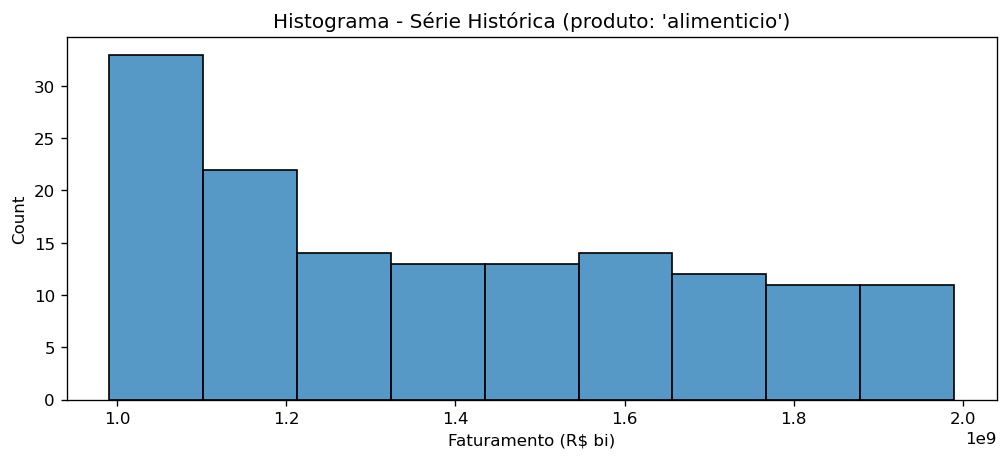

In [71]:
sns.histplot(fat)
plt.xlabel('Faturamento (R$ bi)')
plt.title(f"Histograma - Série Histórica (produto: '{analise_produto}')")
plt.show()

O histograma da série completa parece bastante comportado. Mas vejamos se conseguimos fazer uma análise melhor separando por ano.

In [64]:
n_anos = 4
anos_recentes = fat[fat.index >= dt.datetime.now() - dt.timedelta(days = n_anos * 365) + pd.tseries.offsets.YearBegin()]
anos_recentes.describe()

count    4.500000e+01
mean     1.754887e+09
std      1.276560e+08
min      1.545698e+09
25%      1.665024e+09
50%      1.765983e+09
75%      1.872678e+09
max      1.990000e+09
Name: faturamento_alimenticio, dtype: float64

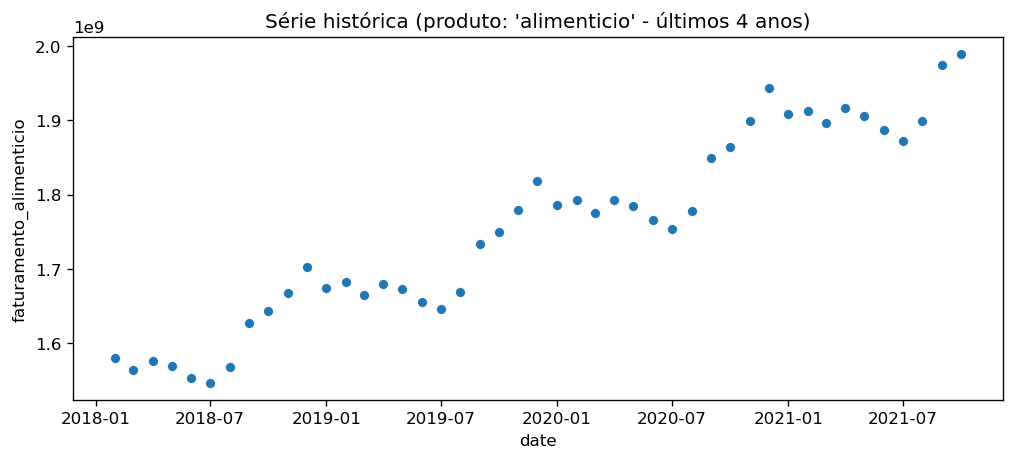

In [65]:
sns.scatterplot(data = anos_recentes)
plt.title(f"Série histórica (produto: '{analise_produto}' - últimos {n_anos} anos)")
plt.show()

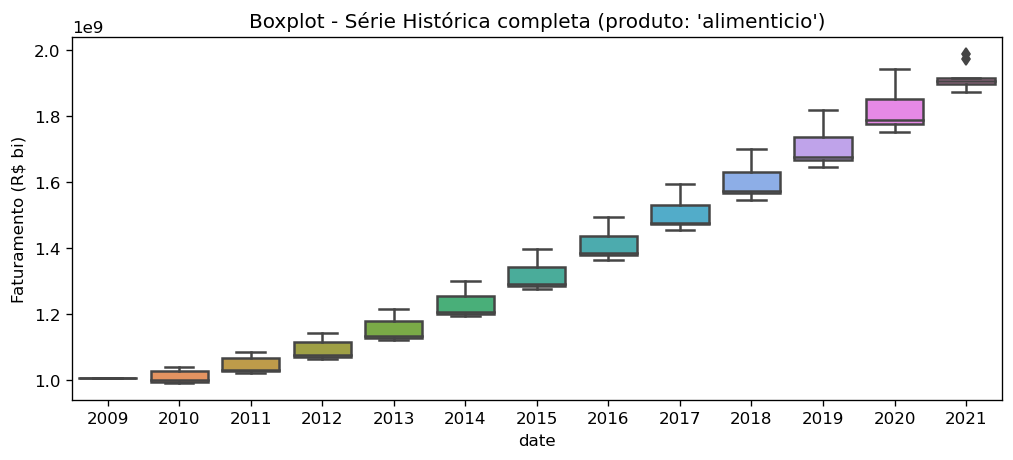

In [70]:
sns.boxplot(y = fat, x = fat.index.year)
plt.ylabel('Faturamento (R$ bi)')
plt.title(f"Boxplot - Série Histórica completa (produto: '{analise_produto}')")
plt.show()

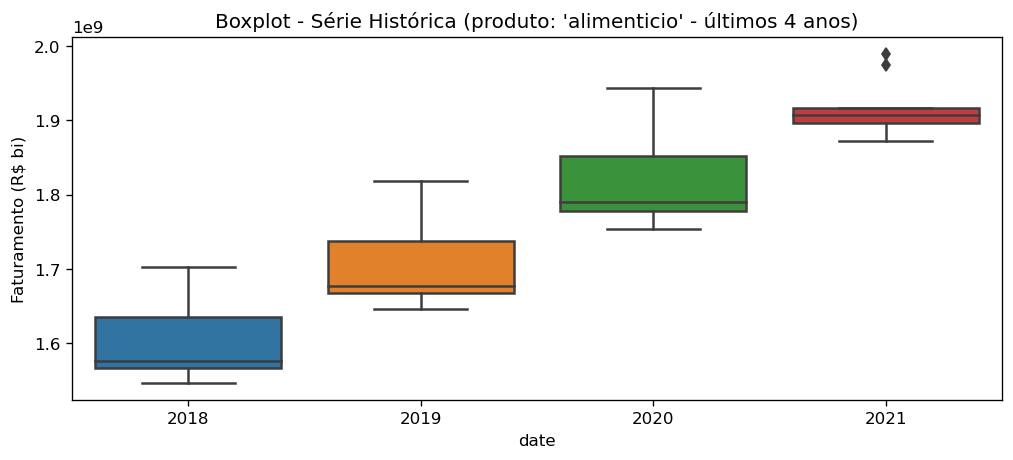

In [69]:

sns.boxplot(y = anos_recentes, x = anos_recentes.index.year)
plt.ylabel('Faturamento (R$ bi)')
plt.title(f"Boxplot - Série Histórica (produto: '{analise_produto}' - últimos {n_anos} anos)")
plt.show()

Observamos o mesmo efeito que no faturamento total - há aparentes *outliers* em 2021 por conta de a série neste ano não estar completa.

### Análise de séries temporais - produto `alimenticio`

Primeiramente, temos que fazer um *set-up*:

In [73]:
decomps = {}
seaborn_palette = sns.color_palette(None, n_produtos)

i_palette = {}
for i, produto in enumerate(produtos):
    i_palette[produto] = i


#### Decomposição em séries de Fourier

Antes de fazermos uma decomposição em séries de Fourier, é necessário checarmos se a série é estacionária. Faremos isso através do teste de Dickey-Fuller, como fizemos para o caso dos faturamentos totais.

In [82]:
testedf = adfuller(fat)
pvalor = testedf[1]
alpha = 0.05

print(f'Valor-p: {pvalor:.3%}', end = '')

if pvalor < alpha:
    print(f' < {alpha:.0%}')
    print('    Série de faturamentos mensais é estacionária. Rejeita-se a hipótese de a série ser um passeio aleatório.')
else:
    print(f' > {alpha:.0%}')
    print('    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).')

Valor-p: 99.613% > 5%
    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).


Confirmamos que a série não é estacionária através da análise de resíduos da decomposição em séries de Fourier:

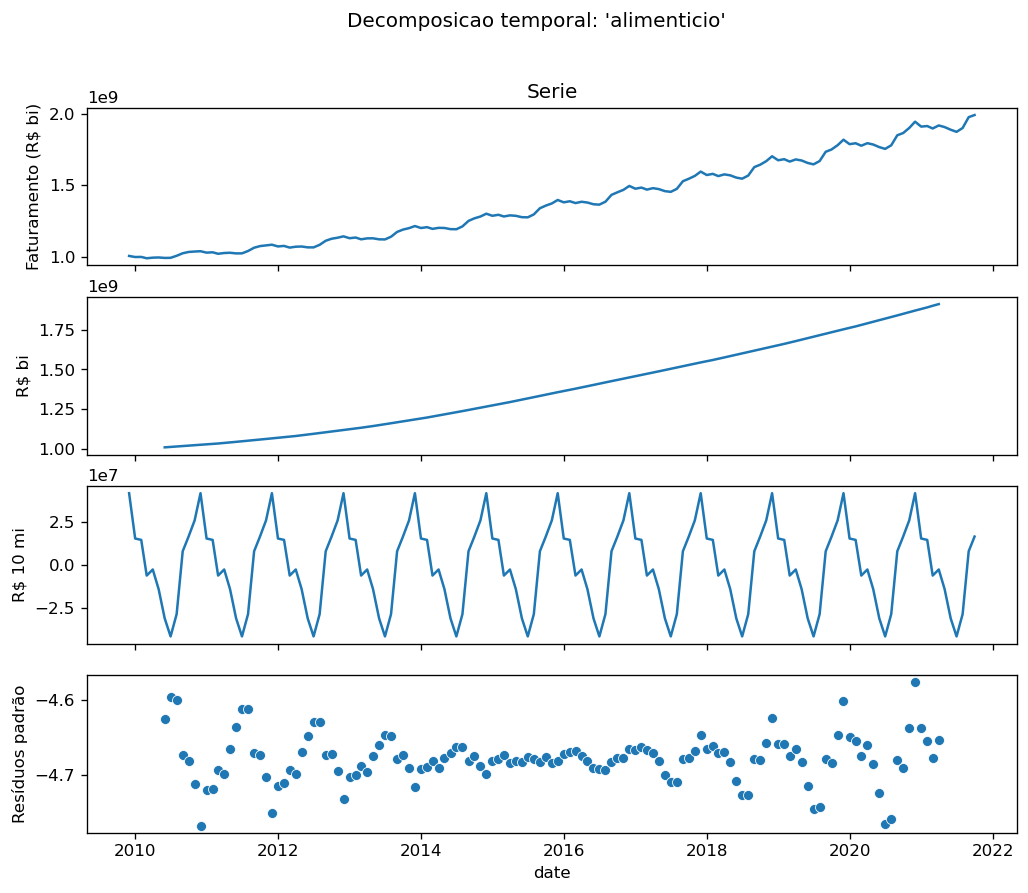

In [84]:
decomps[analise_produto] = seasonal_decompose(fat)
decomp = decomps[analise_produto]

fig, axs = plt.subplots(nrows = 4, figsize = (10, 8), sharex = True)

ts_filtro = tsd[analise_produto]
i = i_palette[analise_produto]
c = palette[i]

sns.lineplot(data = ts_filtro, ax = axs[0], color = c)
axs[0].set_title('Serie')
axs[0].set_ylabel('Faturamento (R$ bi)')

sns.lineplot(data = decomp.trend, ax = axs[1], color = c)
axs[1].set_ylabel('R$ bi')

sns.lineplot(data = decomp.seasonal, ax = axs[2], color = c)
axs[2].set_ylabel('R$ 10 mi')

resid_standard = (decomp.resid - ts_filtro.mean()) / ts_filtro.std()
sns.scatterplot(data = resid_standard, ax = axs[3], color = c)
axs[3].set_ylabel('Resíduos padrão')

fig.suptitle(f"Decomposicao temporal: '{analise_produto}'")
plt.show()

Uma série estacionária teria seus resíduos distribuídos aleatóriamente, com por volta de 99% contidos entre -3 e +3.

Não é o que ocorre aqui. Os resíduos não estão distribuídos aleatoriamente (apresentam um padrão oscilatório), e estão completamente em intervalo negativo.

É necessário um modelo mais complexo.

#### Modelo autorregressivo

Vamos construir um modelo autorregressivo integrável de média móvel com sazonalidade - SARIMA.

De cara já determinamos que a série histórica não é estacionária: logo, a ordem de diferenciação (parâmetros `d` e `D` do modelo) deve ser ao menos 1.

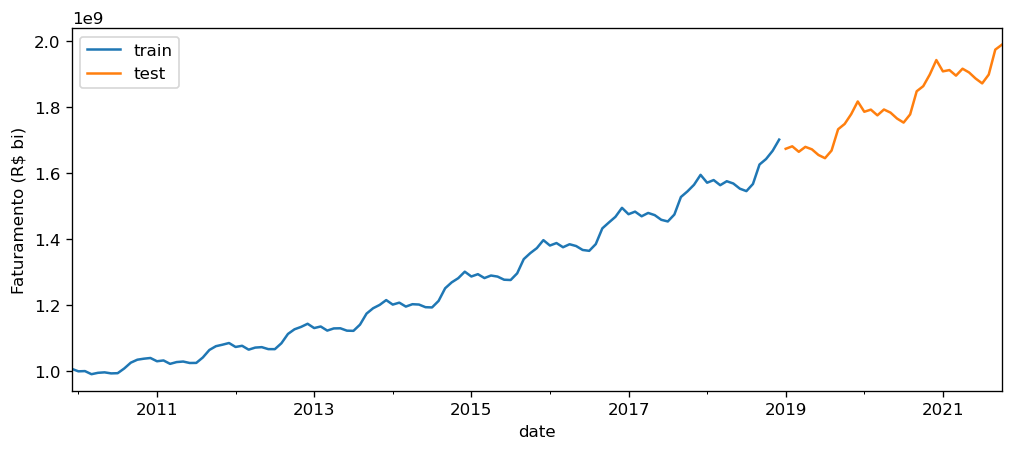

In [115]:
test_begin = '2019-01-01'
fat_train = fat[:test_begin].iloc[:-1]
fat_test = fat[test_begin:]

fat_train.plot(label = 'train')
fat_test.plot(label = 'test')
plt.ylabel('Faturamento (R$ bi)')
plt.legend()
plt.show()

In [116]:
arimas[analise_produto] = auto_arima(
    y = fat_train,
    start_p = 1, max_p = 3,
    d = None, #max_d = 4,
    start_q = 1, max_q = 3,
    start_P = 1, max_P = 3,
    D = None, #max_D = 4,
    start_Q = 1, max_Q = 3,
    #max_order = 6,
    m = 12,
    #alpha = 0.05
)


In [117]:
arimas[analise_produto].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  109
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -1542.798
Date:                            Mon, 15 Nov 2021   AIC                           3089.596
Time:                                    23:21:38   BIC                           3094.725
Sample:                                         0   HQIC                          3091.669
                                            - 109                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7.709e+05   2.53e+05      3.041      0.002    2.74e+05    1.27e+06
sigma2      5.327e+12   9.55e+11      5.577      0.000    3.45e+12     7.2e+12
===================================================================================
Ljung-Box (L1) (Q):                   1.98   Jarque-Bera (JB):                 4.27
Prob(Q):                              0.16   Prob(JB):                         0.12
Heteroskedasticity (H):               1.79   Skew:                             0.45
Prob(H) (two-sided):                  0.11   Kurtosis:                         2.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

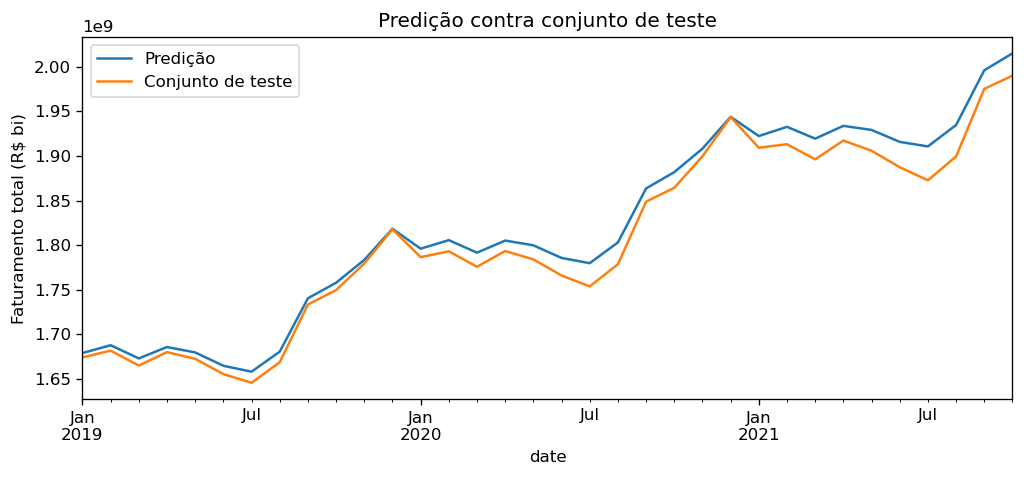

In [118]:
n_test_periods = fat_test.shape[0]
arr_preds = arimas[analise_produto].predict(n_test_periods)

idx = pd.date_range(freq = 'MS', start = test_begin, periods = n_test_periods)
preds = pd.Series(arr_preds, index = idx)
preds.name = 'yearly_preds'

preds.plot(label = 'Predição')
fat_test.plot(label = 'Conjunto de teste')

plt.legend()
plt.ylabel('Faturamento total (R$ bi)')
plt.title('Predição contra conjunto de teste')
plt.show()

Vamos aplicar algumas métricas ao modelo:

In [119]:
kwargs_total = dict(
    y_true = fat_test,
    y_pred = preds
)

metricas[analise_produto] = dict(
    mape = smape(**kwargs_total),
    rmse = np.sqrt(smse(**kwargs_total)),
    mae = smae(**kwargs_total)
)

mape = metricas[analise_produto]['mape']
rmse = metricas[analise_produto]['rmse']
mae = metricas[analise_produto]['mae']

print(f'MAPE: {mape:.3%}')
print(f'RMSE: {rmse:.3e}')
print(f' MAE: {mae:.3e}')

MAPE: 0.812%
RMSE: 1.743e+07
 MAE: 1.485e+07


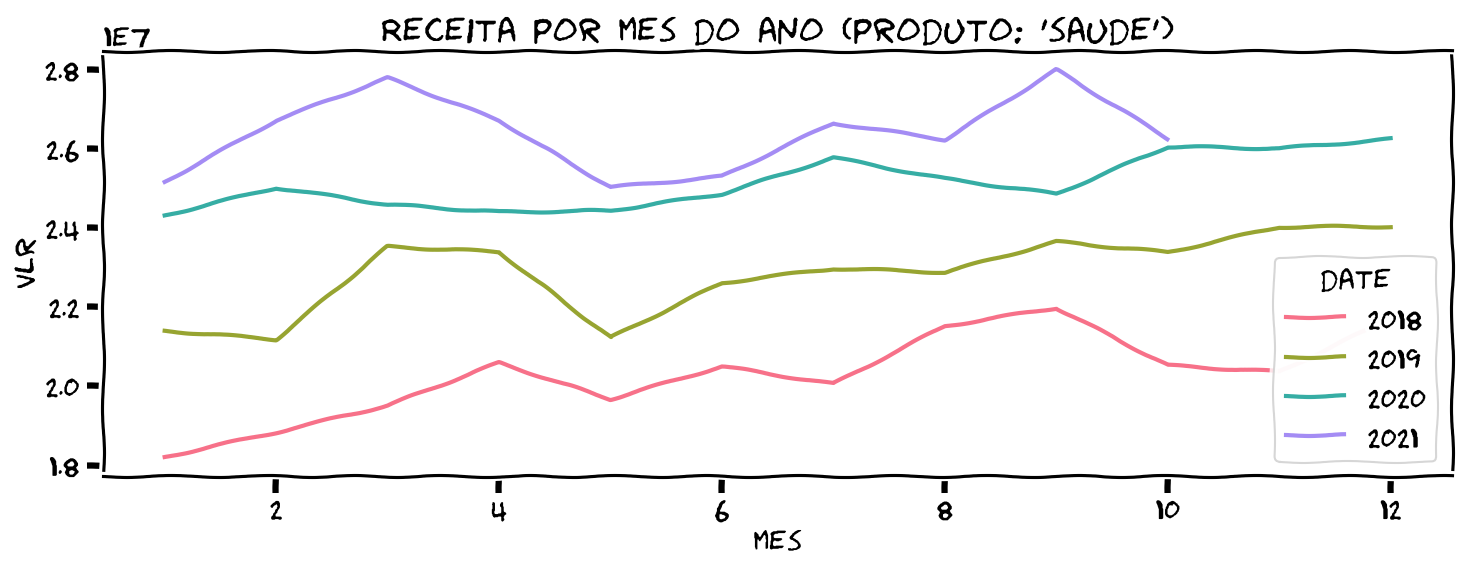

In [10]:
produto = 'saude'
df = ts[(ts.produto == produto) & ((ts.index >= '2018-01-01') | (ts.index >= '2021-12-01'))]
hue = df.index.year
x = df.index.month

with plt.xkcd():
    ax = sns.lineplot(data = df, y = 'vlr', x = x, hue = hue, palette = sns.color_palette('husl', hue.unique().shape[0]))
    ax.set_xlabel('mes')
    ax.set_title(f"Receita por mes do ano (produto: '{produto}')")
    plt.tight_layout()
    plt.show()

## Decomposição em séries de Fourier

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [22]:
decomps = {}

for produto in ts.produto.cat.categories:
    ts_filtro_naoperiodico = ts.loc[ts.produto == produto, 'vlr']
    
    # construindo um indice periodico com o qual o statsmodel consegue trabalhar
    idx_periodico = pd.date_range(
        start = ts_filtro_naoperiodico.index.min(), 
        end = ts_filtro_naoperiodico.index.max(),
        freq = 'MS'
    )
    ts_filtro = ts_filtro_naoperiodico.reindex(idx_periodico)

    # como preenchemos os nans?
    ts_filtro.fillna(0, inplace = True)

    decomps[produto] = seasonal_decompose(ts_filtro)

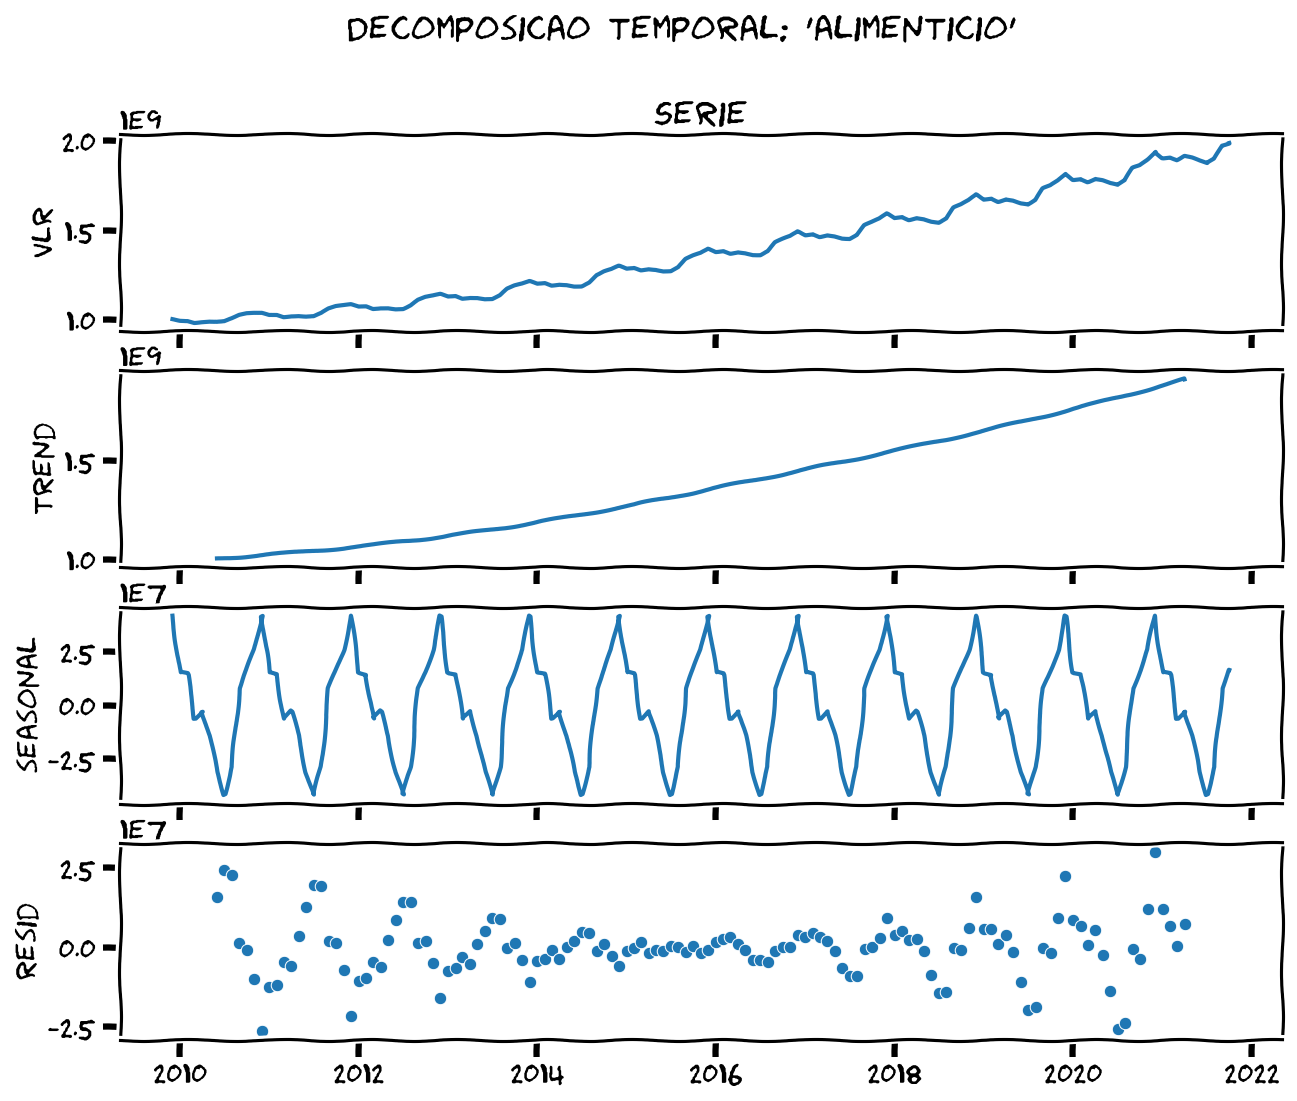

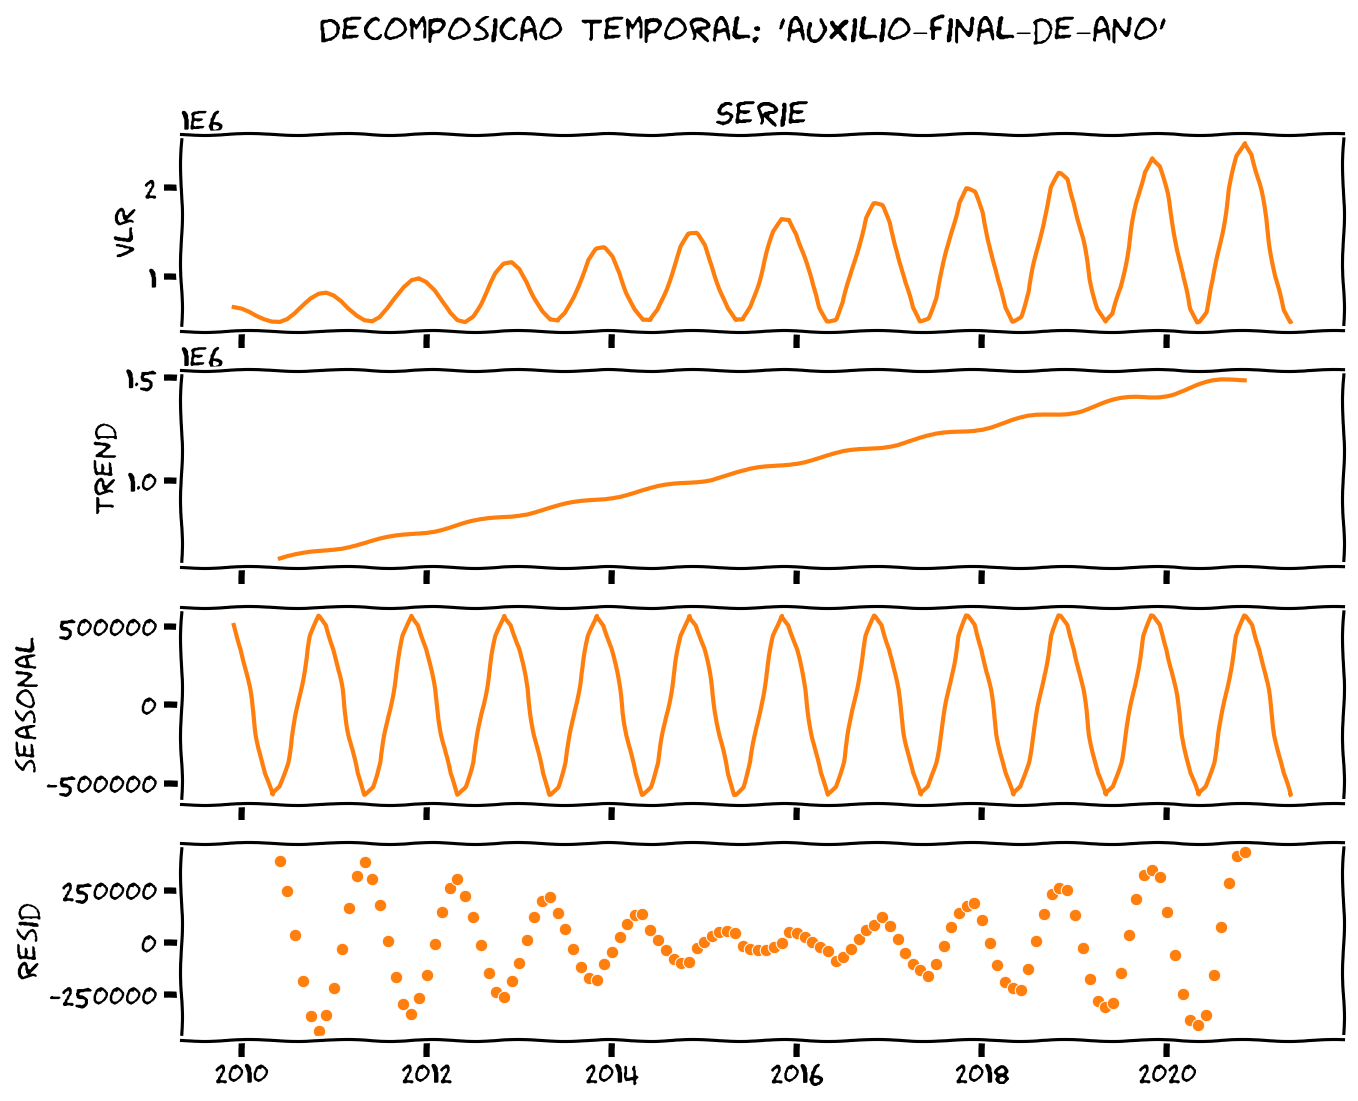

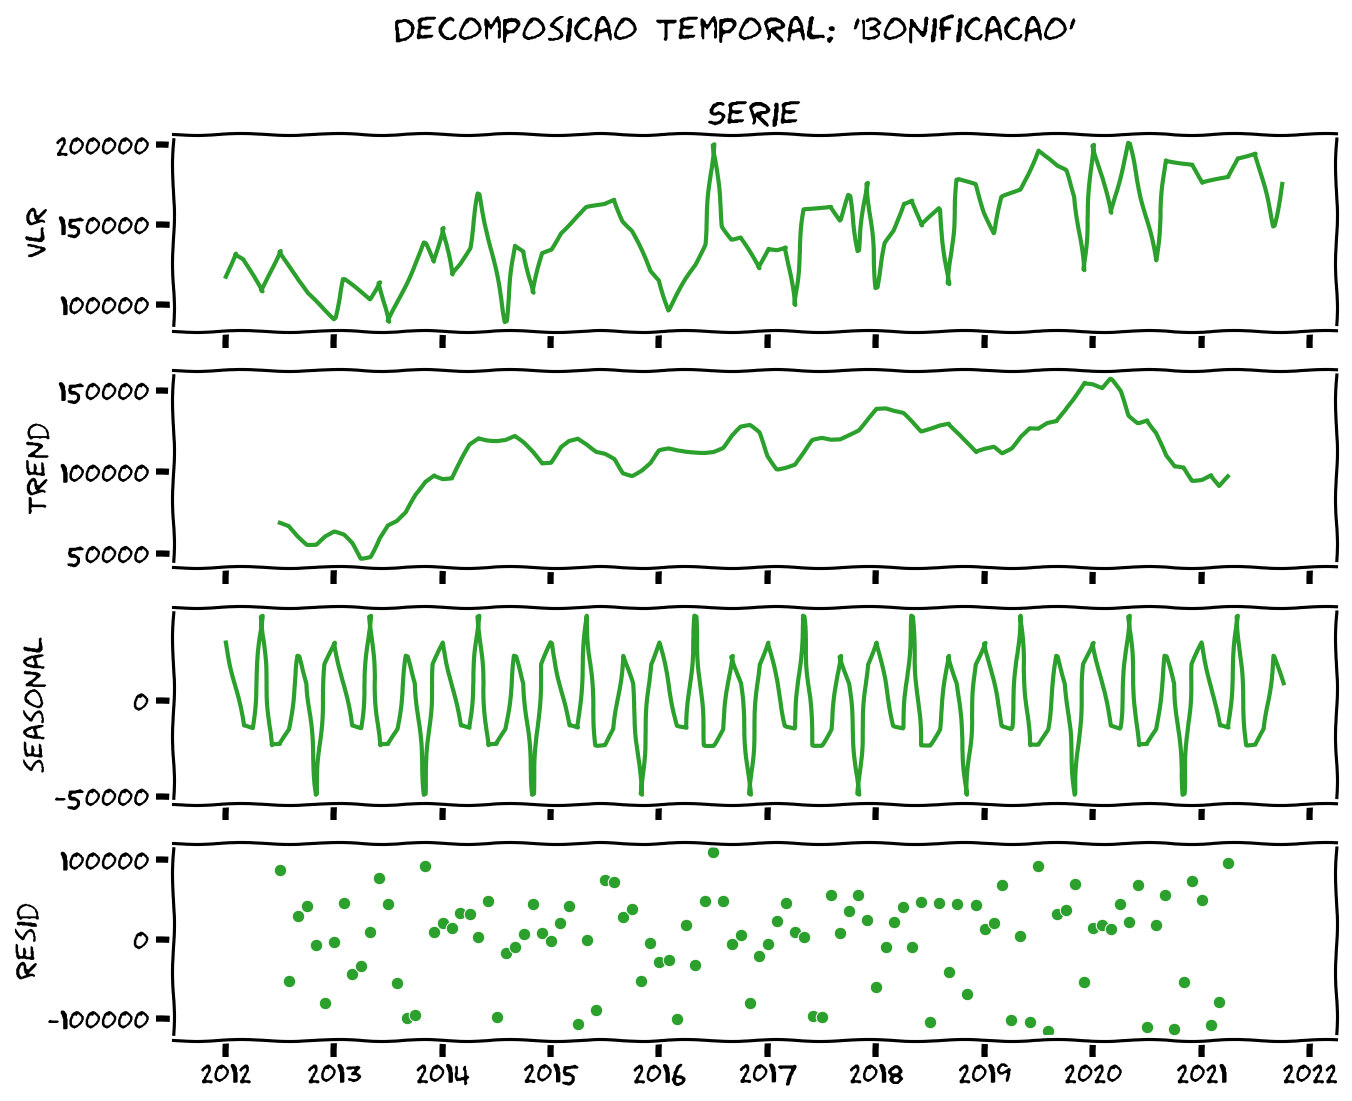

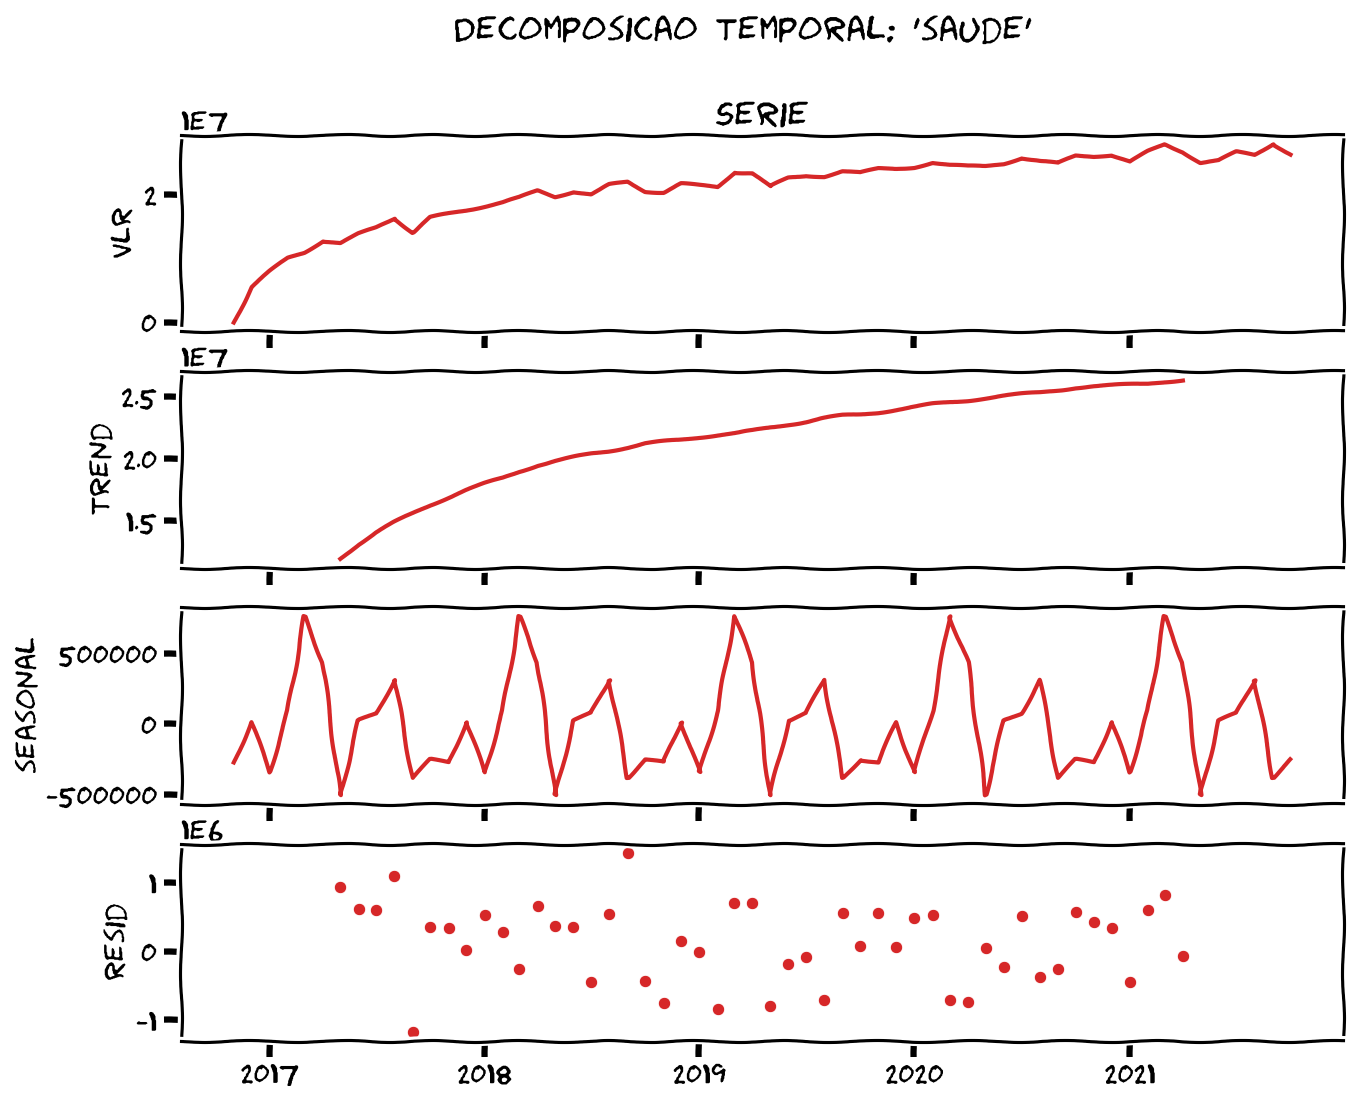

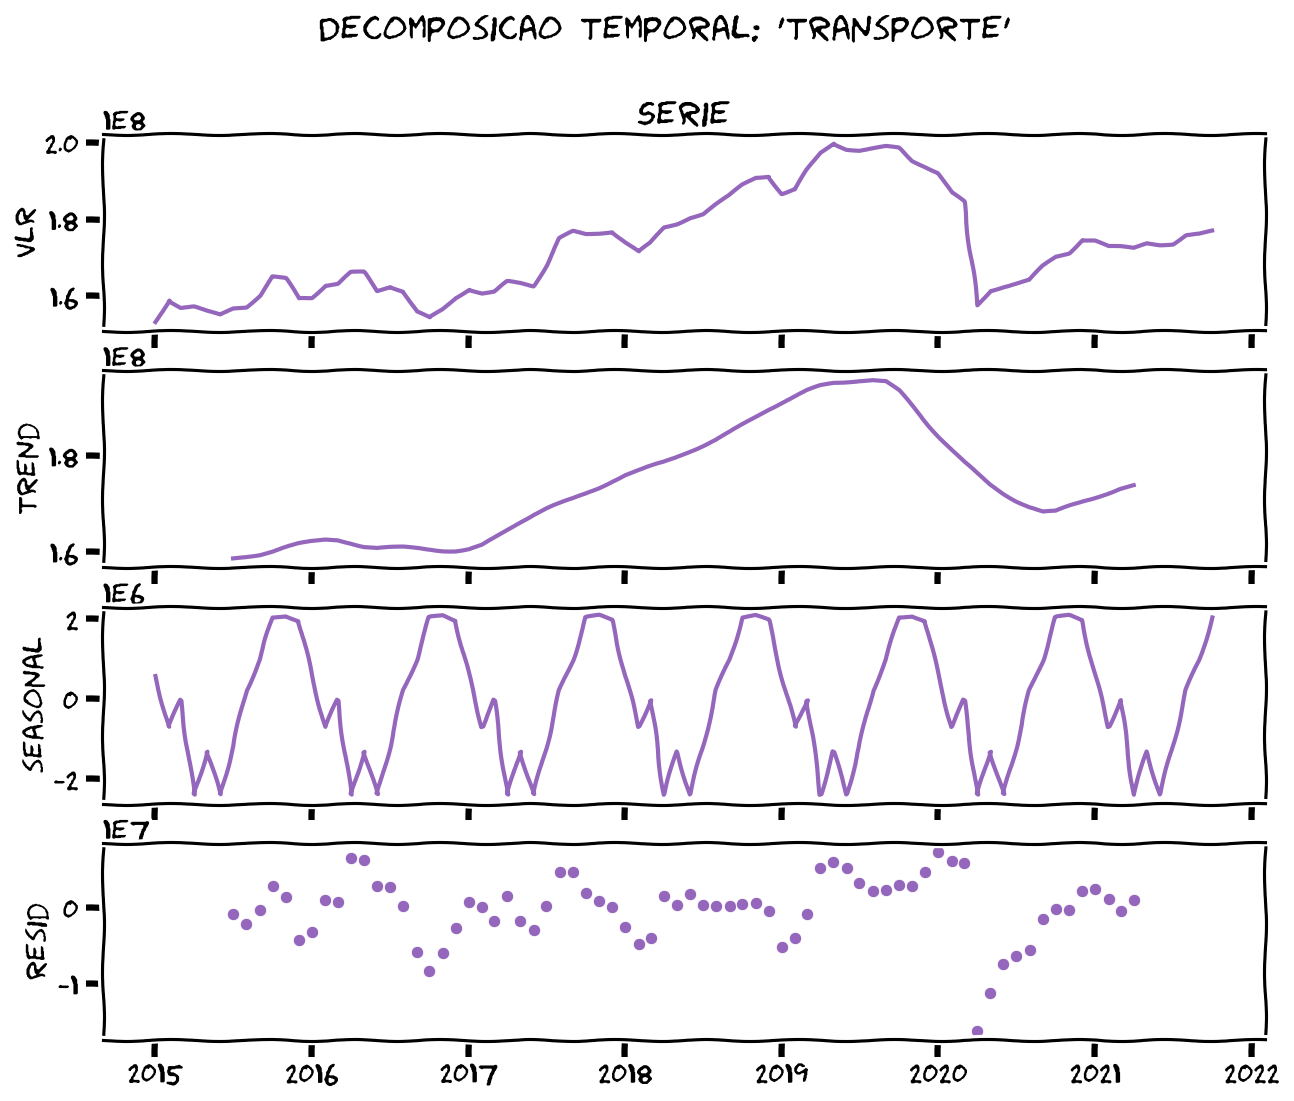

In [39]:
with plt.xkcd():
    n_produtos = len(decomps.keys())
    palette = sns.color_palette(None, n_produtos)

    for i, (produto, decomp) in enumerate(decomps.items()):
        fig, axs = plt.subplots(nrows = 4, figsize = (10, 8), sharex = True)
        ts_filtro = ts.loc[ts.produto == produto, 'vlr']

        c = palette[i]
        
        sns.lineplot(data = ts_filtro, ax = axs[0], color = c)
        axs[0].set_title('Serie')

        sns.lineplot(data = decomp.trend, ax = axs[1], color = c)

        sns.lineplot(data = decomp.seasonal, ax = axs[2], color = c)

        sns.scatterplot(data = decomp.resid, ax = axs[3], color = c)
        
        fig.suptitle(f"Decomposicao temporal: '{produto}'")
        plt.show()

In [45]:
produto


'transporte'

In [46]:
ts_filtro = ts.loc[ts.produto == produto, 'vlr']

In [47]:
ts_filtro

date
2015-01-01    1.532707e+08
2015-02-01    1.590025e+08
2015-03-01    1.570495e+08
2015-04-01    1.572236e+08
2015-05-01    1.559886e+08
                  ...     
2021-06-01    1.735395e+08
2021-07-01    1.737046e+08
2021-08-01    1.759447e+08
2021-09-01    1.761901e+08
2021-10-01    1.768986e+08
Name: vlr, Length: 82, dtype: float64